In [1]:
import numpy as np
import IPython
import scipy.io.wavfile
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy.random as rng
plt.rcParams["figure.figsize"] = (2, 1)

In [2]:
frate, file = scipy.io.wavfile.read("./data/80s-hi.wav")
IPython.display.display( IPython.display.Audio( file, rate=frate))

## part 1

In [3]:
# STFT code from lab 1
from numpy.fft import rfft, irfft, fftfreq


def foward_transform(input_sound, dft_size, hop_size, zero_pad, window):
    input_len = len(input_sound)
    idx = 0
    segments = []
    while idx + dft_size < input_len:
        s = input_sound[idx:idx + dft_size]
        segments.append(np.multiply(s, window))
        idx += hop_size
    else:
        s = np.append(input_sound[idx:-1],
                      np.zeros(idx + dft_size - input_len + 1))
        segments.append(np.multiply(s, window))
    frames = np.array(segments)

    dft_frames = []
    for idx, x in enumerate(frames):
        dft_frames.append(rfft(x, dft_size + zero_pad))
    dft_frames = np.array(dft_frames, dtype=complex)
    return dft_frames


def inverse_transform(input_sound, dft_size, hop_size, zero_pad, window):
    leng = hop_size * (len(input_sound) - 1) + dft_size + zero_pad
    output = np.zeros(leng, dtype=complex)
    for idx, row in enumerate(input_sound):
        frame = np.multiply(irfft(row, dft_size + zero_pad)[:dft_size], window)
        output[idx * hop_size:idx * hop_size + dft_size] += frame
    return output


def stft(input_sound, dft_size, hop_size, zero_pad, window):
    if input_sound.ndim == 1 and np.isreal(input_sound).all():
        return foward_transform(input_sound, dft_size, hop_size, zero_pad,
                                window)
    else:
        return inverse_transform(input_sound, dft_size, hop_size, zero_pad,
                                 window)


def plot_stft(input_sound,
              stft,
              dft_size,
              hop_size,
              zero_pad,
              frate,
              title=""):
    output = np.absolute(stft)**0.3
    time = np.linspace(0, output.shape[0] * hop_size / frate, output.shape[0])
    freq = np.linspace(0, frate / 2, int((dft_size + zero_pad) / 2 + 1))
    plt.pcolormesh(time, freq, output.T)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (HZ)")
    plt.title(title)
    plt.show()


def plot_sound(input_sound, fs, title='input_sound'):
    plt.plot(np.linspace(0,
                         len(input_sound) / fs, len(input_sound)), input_sound)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.show()

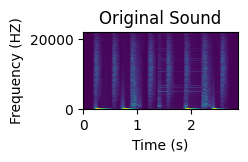

In [4]:
dft_size = 4096
Hann_window = np.hanning(dft_size)
hop_size = 256
zero_pad = 0

zeros = np.zeros(dft_size*3)
file = np.concatenate((zeros, file))




F = stft(file, dft_size, hop_size, zero_pad, Hann_window)
plot_stft(file, F, dft_size, hop_size, zero_pad, frate, "Original Sound")
F = F.T

In [5]:
K = 4
W = rng.uniform(10, 11, (F.shape[0], K))
H = rng.uniform(10, 11, (K, F.shape[1]))
for j in range(4): 
    W[:,j] /= np.sum(W[:,j])
for i in range(100):
    V = np.absolute(F) / (W @ H +  1e-6)
    H = H * (W.T@V)
    W = W * (V@H.T)
    for j in range(4): 
        W[:,j] /= np.sum(W[:,j])

### Plots of columns of W. Each column is a frequency factor

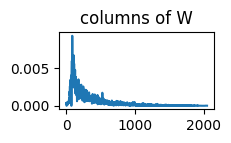

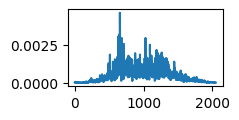

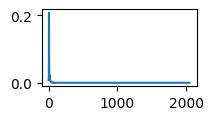

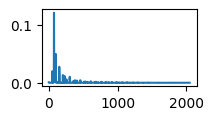

In [6]:
plt.plot(W[:,0])
plt.title("columns of W")
plt.figure()
plt.plot(W[:,1])
plt.figure()
plt.plot(W[:,2])
plt.figure()
plt.plot(W[:,3])
plt.show()

### Plots of rows of H. Each row is a time factor.

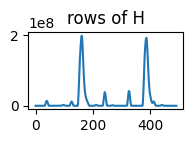

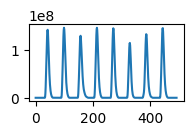

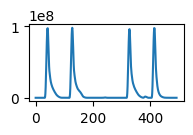

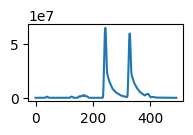

In [7]:
plt.plot(H[0])
plt.title("rows of H")
plt.figure()
plt.plot(H[1])
plt.figure()
plt.plot(H[2])
plt.figure()
plt.plot(H[3])
plt.show()

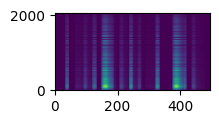

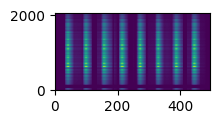

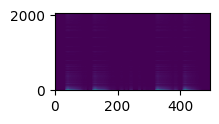

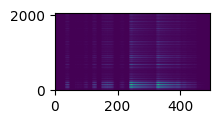

In [8]:
res = []
for i in range(4):
    product = np.outer(W[:,i], H[i])
    plt.figure()
    plt.pcolormesh(np.absolute(product)**0.3)
    res.append(stft((product*np.angle(F)).T,  dft_size, hop_size, zero_pad, Hann_window))
res = np.real(res)

### Each of the sounds corresponds to one of the instruments! 

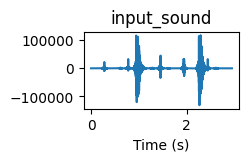

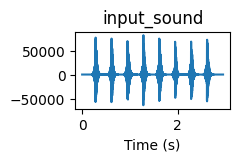

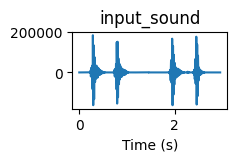

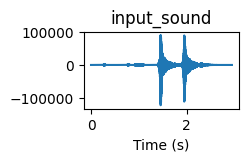

In [9]:
for sound in res:
    plt.figure()
    plot_sound(sound, frate)
    IPython.display.display( IPython.display.Audio( sound, rate=frate))

### We now have the reconstructed sound, which is fairly close to the original one 

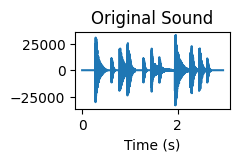

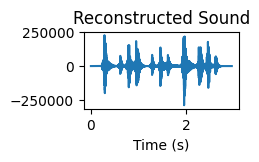

In [10]:
plot_sound(file, frate, "Original Sound")
IPython.display.display( IPython.display.Audio( file, rate=frate))
recon = np.sum(res, axis=0)
plot_sound(recon, frate, "Reconstructed Sound")
IPython.display.display( IPython.display.Audio( recon, rate=frate))

## part 2

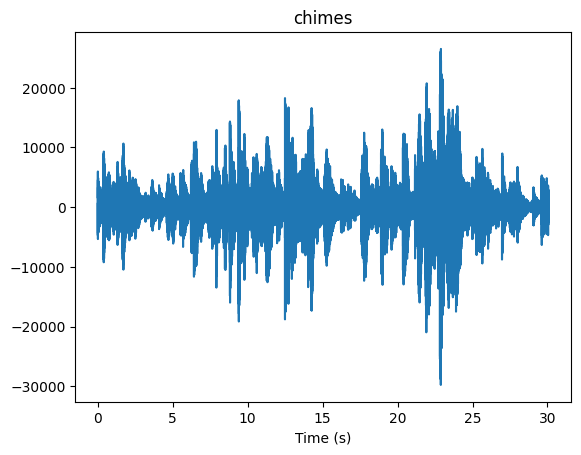

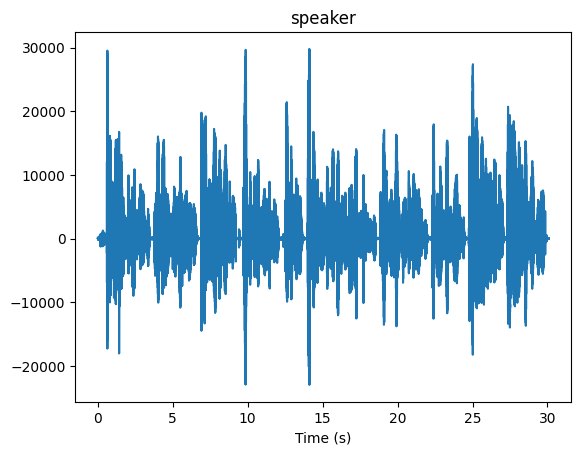

In [11]:
frate1, file1 = scipy.io.wavfile.read("./data/chimes.wav")
IPython.display.display( IPython.display.Audio( file1, rate=frate1))
plot_sound(file1, frate1, "chimes")
frate2, file2 = scipy.io.wavfile.read("./data/speaker.wav")
IPython.display.display( IPython.display.Audio( file2, rate=frate2))
plot_sound(file2, frate2, "speaker")

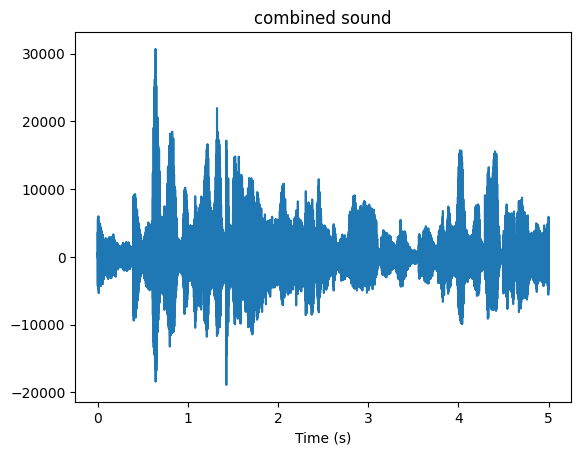

In [12]:
dft_size = 4096
Hann_window = np.hanning(dft_size)
hop_size = 128
zero_pad = 0

sec1 = file1[:5*frate1]
sec2 = file2[:5*frate2]
mix = sec1 + sec2
plot_sound(mix, frate1, "combined sound")
IPython.display.display( IPython.display.Audio( mix, rate=frate1))

In [13]:
res1 = file1[5*frate1:]
res2 = file2[5*frate2:]

In [14]:
def getW(input_file, title=""):
    F = stft(input_file, dft_size, hop_size, zero_pad, Hann_window)
    plot_stft(input_file, F, dft_size, hop_size, zero_pad, frate1, title)
    F = F.T
    K = 40
    W = rng.uniform(10, 11, (F.shape[0], K))
    H = rng.uniform(10, 11, (K, F.shape[1]))
    for j in range(K): 
        W[:,j] /= np.sum(W[:,j])
    for i in range(100):
        V = np.absolute(F) / (W @ H +  1e-6)
        H = H * (W.T@V)
        W = W * (V@H.T)
        for j in range(K): 
            W[:,j] /= np.sum(W[:,j])
    return W

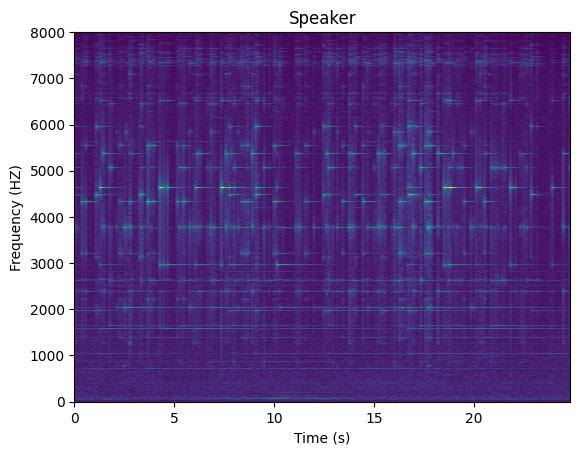

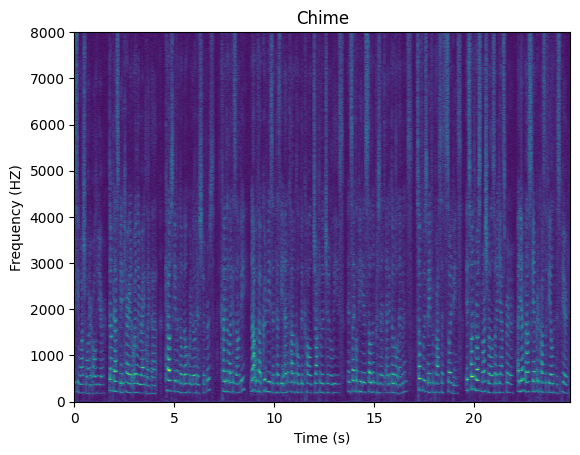

In [15]:
Ws = getW(res1, "Speaker")
Wc = getW(res2, "Chime")

In [16]:
def getH(input_file, W, title=""):
    F = stft(input_file, dft_size, hop_size, zero_pad, Hann_window)
    plot_stft(input_file, F, dft_size, hop_size, zero_pad, frate1, title)
    F = F.T
    K = 80
    H = rng.uniform(10, 11, (K, F.shape[1]))
    for i in range(100):
        V = np.absolute(F) / (W @ H +  1e-6)
        H = H * (W.T@V)
    return H

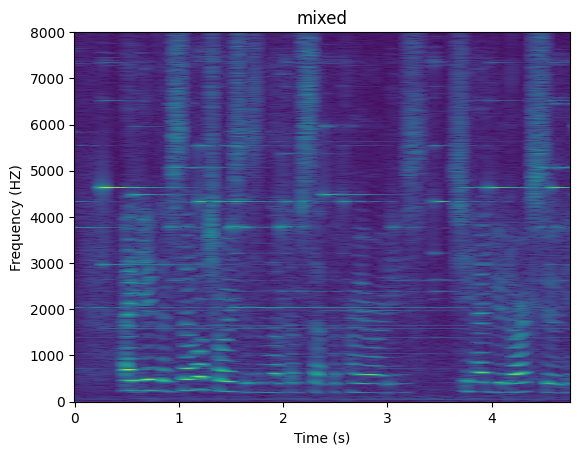

(80, 594)


In [17]:
H = getH(mix, np.concatenate([Ws, Wc], axis=1), 'mixed')
Hs = H[:40]
Hc = H[40:80]
print(H.shape)

In [18]:
Fs = Ws@Hs
Fc = Wc@Hc

In [19]:
def reconstruct(F_input):
    res = []
    for i in range(40):
        product = F_input
        res.append(stft((product*np.angle(stft(mix, dft_size, hop_size, zero_pad, Hann_window).T)).T,  dft_size, hop_size, zero_pad, Hann_window))
    recon = np.real(np.sum(res, axis=0))
    plot_sound(recon, frate1, "reconstructed sound")
    IPython.display.display( IPython.display.Audio( recon, rate=frate1))

### First we have the sound of the Chime 

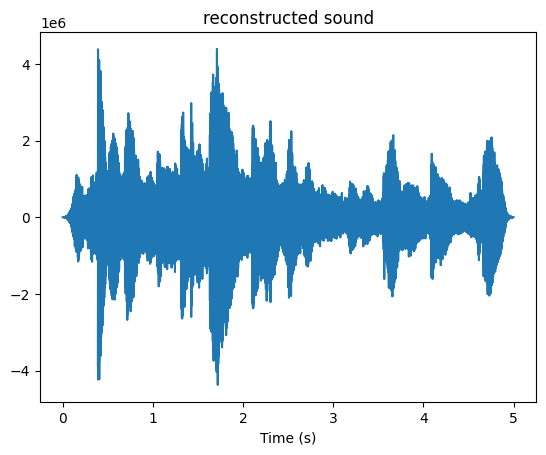

In [20]:
reconstruct(Fs)

### And then the sound of the speaker

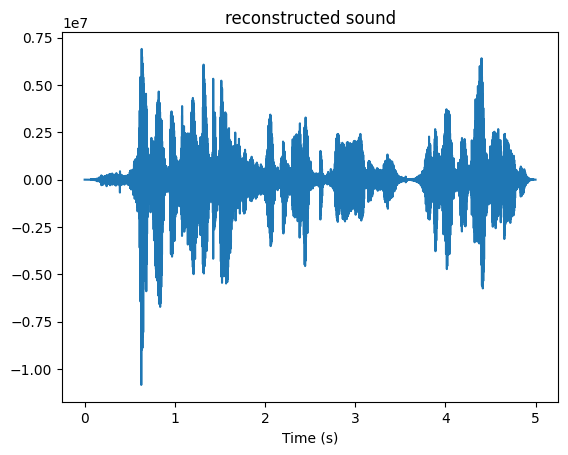

In [21]:
reconstruct(Fc)

#### I used a smaller hop size and it seemed to make the speaker voice sound cleaner.